# Proyecto final: segmentación semántica usando Unet 
Se utiliza la red neuronal convolucional Unet que proporciona el modulo tf_net...

In [9]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from tf_unet import unet, util, image_util
%matplotlib inline

Using TensorFlow backend.


### Preparación de los conjuntos de entrenamiento y prueba

In [2]:
training_data = []
test_data = []

len_training = 2975
len_test = 500

for i in range(len_training):
    im = cv2.imread('dataset/train/' + str(i+1) + '.jpg', 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    training_data.append(im)

for i in range(len_test):
    im = cv2.imread('dataset/train/' + str(i+1) + '.jpg', 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    test_data.append(im)

In [152]:
img_dim = 256
x_training = np.array([training_data[i][:,:img_dim] for i in range(len_training)])
y_training = np.array([training_data[i][:,img_dim:] for i in range(len_training)])

x_test = np.array([test_data[i][:,:img_dim] for i in range(len_test)])
y_test = np.array([test_data[i][:,img_dim:] for i in range(len_test)])

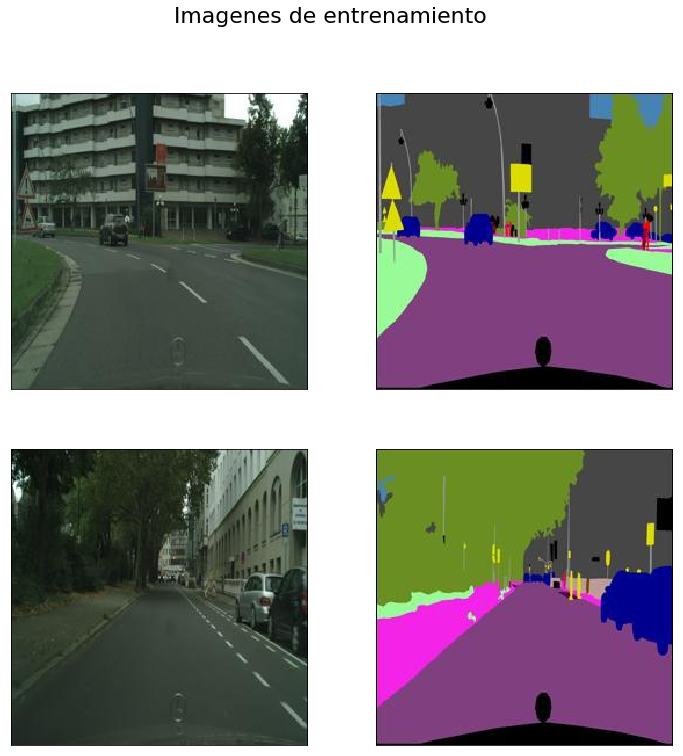

In [154]:
plt.figure(figsize=(12, 12)).suptitle('Imagenes de entrenamiento', fontsize=22)
for i in range(4):
    plt.subplot(2,2,i+1)
    if (i+1)%2!=0:
        plt.imshow(x_training[i])
    else:
        plt.imshow(y_training[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [125]:
#data_provider = image_util.ImageDataProvider("dataset/train/*.tif")

### Creacion de la red neuronal Unet

In [112]:
from keras.layers import Dense, Conv2D, Dropout, Activation, Flatten, MaxPooling2D, UpSampling2D, Input, merge
from keras.optimizers import Adam

In [42]:
n_filters = 5
kernel_size = (3, 3)
pool_size = (2, 2)
pool_stride = (2, 2)
ups_size = (2, 2)
input_shape = (256, 256, 3)

## Defininir la arquitectura de la red neuronal 
La arquitectura de la red neuronal es como se muestra en la siguiente imagen:

In [76]:
%%html
<img src="imgs/u-net-architecture.png", width=512, height=512>

Mediante el modulo Keras se implementará la red, añadiendo cada una de las capas y conectandolas entre si.

La red neuronal se divide en 3 partes:

1. Codificación (4 etapas): Consiste de 2 operaciones de convolución y una de max pooling.
2. Cuello de botella (1 etapa): Consiste de 2 operaciones de convolucion y una de up sampling.
3. Decodificación (4 etapas): Consiste en concatenar las convoluciones finales de cada etapa con la salida que produce el up sampling, para posteriormente aplicar 2 convoluciones y un up sampling.

Adicionalmente, se agregaran 2 capas de dropout con el fin de evitar que haya overfitting en el conjunto de datos de entrenamiento.

In [155]:
# Encoder
input_shape = (256, 256, 3)

inputs = Input(input_shape)
conv1 = Conv2D(64, 3, padding='same', activation='relu')(inputs)
conv1 = Conv2D(64, 3, padding='same', activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=pool_size, strides=pool_stride)(conv1)

conv2 = Conv2D(128, kernel_size, padding='same', activation='relu')(pool1)
conv2 = Conv2D(128, kernel_size, padding='same', activation='relu')(conv2)
pool2 = MaxPooling2D(pool_size=pool_size, strides=pool_stride)(conv2)

conv3 = Conv2D(256, kernel_size, padding='same', activation='relu')(pool2)
conv3 = Conv2D(256, kernel_size, padding='same', activation='relu')(conv3)
pool3 = MaxPooling2D(pool_size=pool_size, strides=pool_stride)(conv3)

conv4 = Conv2D(512, kernel_size, padding='same', activation='relu')(pool3)
conv4 = Conv2D(512, kernel_size, padding='same', activation='relu')(conv4)
drop4 = Dropout(0.5)(conv4)       # Dropout
pool4 = MaxPooling2D(pool_size=pool_size, strides=pool_stride)(drop4)

# Cuello de botella
conv5 = Conv2D(1024, kernel_size, padding='same', activation='relu')(pool4)
conv5 = Conv2D(1024, kernel_size, padding='same', activation='relu')(conv5)
drop5 = Dropout(0.5)(conv5)
upsa5 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size=ups_size)(drop5))
#upsa5 = UpSampling2D(size=ups_size, interpolation='nearest')(drop5)

# Decoder

merge6 = merge.concatenate([upsa5 , drop4], axis=3)
conv6 = Conv2D(512, kernel_size, padding='same', activation='relu')(merge6)
conv6 = Conv2D(512, kernel_size, padding='same', activation='relu')(conv6)
upsa6 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size=ups_size)(conv6))
#upsa6 = UpSampling2D(size=ups_size)(conv6)

merge7 = merge.concatenate([conv3, upsa6], axis=3)
conv7 = Conv2D(256, kernel_size, padding='same', activation='relu')(merge7)
conv7 = Conv2D(256, kernel_size, padding='same', activation='relu')(conv7)
upsa7 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size=ups_size)(conv7))
#upsa7 = UpSampling2D(size=ups_size)(conv7)

merge8 = merge.concatenate([conv2, upsa7], axis=3)
conv8 = Conv2D(128, kernel_size, padding='same', activation='relu')(merge8)
conv8 = Conv2D(128, kernel_size, padding='same', activation='relu')(conv8)
upsa8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size=ups_size)(conv8))
#upsa8 = UpSampling2D(size=ups_size)(conv8)


# Etapa final
merge9 = merge.concatenate([conv1, upsa8], axis=3)
conv9 = Conv2D(64, kernel_size, padding='same', activation='relu')(merge9)
conv9 = Conv2D(64, kernel_size, padding='same', activation='relu')(conv9)
conv9 = Conv2D(2, kernel_size, padding='same', activation='relu')(conv9)

outputs = Conv2D(3, 1, activation='sigmoid')(conv9)

In [156]:
cnn = keras.Model(input=inputs, output=outputs)
cnn.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_538 (Conv2D)             (None, 256, 256, 64) 1792        input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_539 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_538[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_105 (MaxPooling2D (None, 128, 128, 64) 0           conv2d_539[0][0]                 
__________________________________________________________________________________________________
conv2d_540

/home/dsvart/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  """Entry point for launching an IPython kernel.


In [158]:
%%time
#cnn.fit(x_training, y_training, batch_size=8, epochs=5)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10.7 µs
